# Selecting XTalk Robust MS Modes

## Imports

In [1]:
import tools.IonChainTools as ict
import tools.MSFidelityEstimation as msfe

import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sb

import numpy as np
from itertools import combinations

## Tools

In [2]:
def calcBestModes(chainlens, bw_vals, mode_type="axial", νratio=None):
    ''' Calculate the mode that will give the best fidelity for the MS gate for each pair of ions
    in chains of various length with various xtalk levels.
    
    First calculates rough fidelity estimate using smallTN model. Only calculates fidelities using exactTN model if
    smallTN error is below 1.
    
    '''
    fids = {}
    if mode_type == "axial":
        calcModes = ict.calcAxialModes
    elif mode_type == "radial":
        calcModes = lambda N: ict.calcRadialModes(N, νratio=νratio)
    for N in chainlens:
        mvecs = calcModes(N)
        if mode_type=="axial":
            COMmode = 0
        else:
            COMmode = N-1
        for bw in bw_vals:
            for targets in combinations(range(N), 2):
                intensities = ict.calcCrosstalkIntensities(N, targets, bw)
                COMmvec = mvecs[COMmode][1]
                i,j = targets
                COMspeed = COMmvec[i]*COMmvec[j]
                for m in range(N):
                    mvec = mvecs[m][1]
                    relspeed = abs(mvec[i]*mvec[j]/COMspeed)
                    if relspeed < 1/10:
                        fids[(N,m,(i,j),bw)] = -1
                        continue
                    smallTN_fid = msfe.estimateMSFidelity_errgate_smallTN(N, m, targets, bw,
                                                             mvec=mvec, intensities=intensities,
                                                            mode_type=mode_type, νratio=νratio)
                    if smallTN_fid < -1:
                        fids[(N,m,(i,j),bw)] = smallTN_fid
                        continue
                    fid = msfe.estimateMSFidelity_errgate_exactTN(N, m, targets, bw,
                                                     mvec=mvec, intensities=intensities,
                                                    mode_type=mode_type, νratio=νratio)
                    fids[(N,m,(i,j),bw)] = fid
    rough_fids = fids
    fids = {}
    for N in chainlens:
        if mode_type=="axial":
            COMmode = 0
        else:
            COMmode = N-1
        for bw in bw_vals:
            for targets in combinations(range(N), 2):
                bestmode = np.argmax([rough_fids[(N, m, targets, bw)] for m in range(N)])
                #bestfid = simMSFidelity(N, bestmode, targets, bw)
                #comfid = simMSFidelity(N, 0, targets, bw)
                comfid = msfe.estimateMSFidelity_errgate_exactTN(N, COMmode, targets, bw,
                                                    mode_type=mode_type, νratio=νratio)
                if bestmode != COMmode:
                    bestfid = msfe.estimateMSFidelity_errgate_exactTN(N, bestmode, targets, bw,
                                                         mode_type=mode_type, νratio=νratio)
                else:
                    bestfid = comfid
                fids[(N, targets, bw, "best")] = (bestmode, bestfid)
                fids[(N, targets, bw, "COM")] = (COMmode, comfid)
    best_and_COM_fids = fids
    return best_and_COM_fids

In [3]:
def nines(fid):
    '''Nines of fidelity
    Computes number of nines in fid. For example, 0.9 -> 1, 0.99 -> 2. 0.995 -> 2.3
    If fid is 1, it returns 10 instead of infinity
    '''
    if fid==1:
        return 10
    else:
        return min(10, -np.log10(1-fid))

## Data Generation

### Example

In [4]:
calcBestModes([2,3], [1], mode_type="axial")

{(2, (0, 1), 1, 'best'): (0, 1),
 (2, (0, 1), 1, 'COM'): (0, 1),
 (3, (0, 1), 1, 'best'): (2, 0.9541956265978184),
 (3, (0, 1), 1, 'COM'): (0, 0.9276609308652409),
 (3, (0, 2), 1, 'best'): (1, 1.0),
 (3, (0, 2), 1, 'COM'): (0, 0.6092772091913728),
 (3, (1, 2), 1, 'best'): (2, 0.9541956265978728),
 (3, (1, 2), 1, 'COM'): (0, 0.9276609308652605)}

### Data

In [5]:
Nmax = 20
chainlens = np.arange(2, Nmax+1, 2)
bw_vals = np.arange(0.1, 0.75, 0.05)

In [6]:
bestmodes_axial = calcBestModes(chainlens, bw_vals, mode_type="axial")

## Improvement from Mode Choice

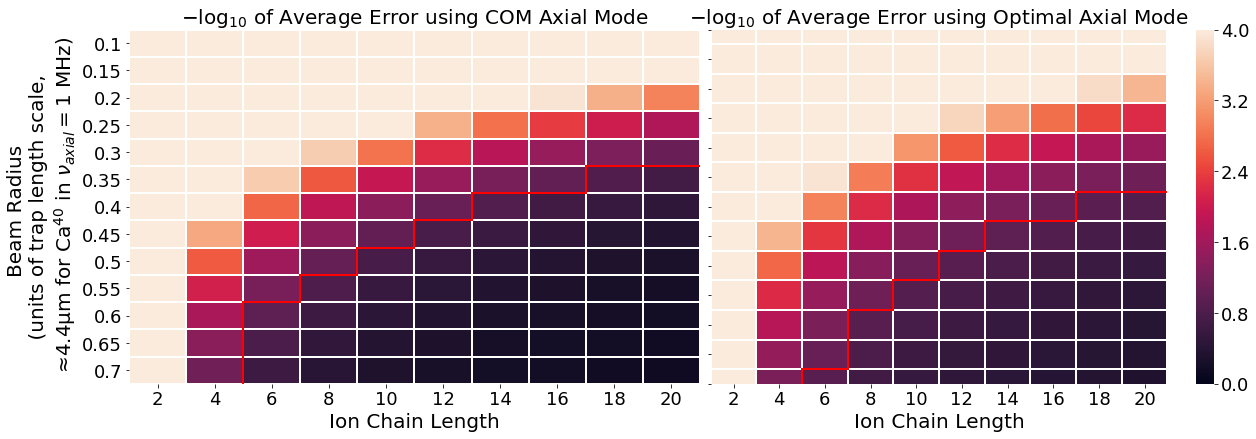

In [20]:
COMavgs = {}
bestavgs = {}
bw_vals_plot = bw_vals
chainlens_plot = chainlens #[N for Ni,N in enumerate(chainlens) if Ni%2==0]
for N in chainlens_plot:
    for bw in bw_vals_plot:
        avg_best = np.mean([bestmodes_axial[(N, targets, bw,"best")][1] for targets in combinations(range(N),2)])
        avg_COM = np.mean([bestmodes_axial[(N, targets, bw,"COM")][1] for targets in combinations(range(N),2)])
        COMavgs[(N, bw)] = nines(avg_COM) if nines(avg_COM) < 10 else 100
        bestavgs[(N,bw)] = nines(avg_best) if nines(avg_best) < 10 else 100
COMgrid = np.zeros((len(chainlens_plot), len(bw_vals_plot)))
bestgrid = np.zeros((len(chainlens_plot), len(bw_vals_plot)))
for Ni, N in enumerate(chainlens_plot):
    for bwi, bw in enumerate(bw_vals_plot):
        COMgrid[Ni,bwi] = COMavgs[(N, bw)]
        bestgrid[Ni,bwi] = bestavgs[(N, bw)]
        
bw_labels = [round(bw,2) for bw in bw_vals_plot]

fig, axes = plt.subplots(1,2, figsize=(18,6), sharey=True)#, width_ratios=[1, 1.25])
for ax, grid in zip(axes, enumerate((COMgrid, bestgrid))):
    gridnum, grid = grid
    gridlabels = [[f"{grid[Ni, bwi]:.2f}" if grid[Ni, bwi]<=10 else '-'
                   for Ni in range(len(chainlens_plot))] for bwi in range(len(bw_vals_plot))]
    cbarax = sb.heatmap(ax=ax, data=grid.T, vmin=0, vmax=4,  fmt="", linewidth=1,
           xticklabels=chainlens_plot, yticklabels=bw_labels,
           cbar=(gridnum==1),cbar_ax=None if gridnum==1 else ax, annot_kws={"fontsize":18})#annot=gridlabels,
    for Ni, N in enumerate(chainlens_plot):
        for bwi, bw in enumerate(bw_vals_plot):
            if Ni==0 or bwi==0: pass
            if grid[Ni,bwi]<1:
                if grid[Ni,bwi-1]>=1:
                    ax.plot((Ni,Ni+1), (bwi,bwi),c="r",lw=2)
                if grid[Ni-1,bwi]>=1:
                    ax.plot((Ni,Ni), (bwi,bwi+1),c="r",lw=2)
    ax.tick_params(rotation=0)
    cbarax.figure.axes[-1].tick_params(labelsize=18)
    
    ax.tick_params(labelsize=18)
    
#plt.set_ax(axes[0])
axes[0].set_xlabel("Ion Chain Length", fontsize=20)
axes[1].set_xlabel("Ion Chain Length", fontsize=20)
axes[0].set_ylabel("Beam Radius \n (units of trap length scale, \n ≈4.4μm for Ca$^{40}$ in $ν_{axial} = 1$ MHz)", fontsize=20)


fig.tight_layout()
axes[0].set_title("$-\log_{10}$ of Average Error using COM Axial Mode", fontsize=20)
axes[1].set_title("$-\log_{10}$ of Average Error using Optimal Axial Mode", fontsize=20)
#plt.title("Average Fidelity
plt.show()

## Best vs COM Gate Speeds

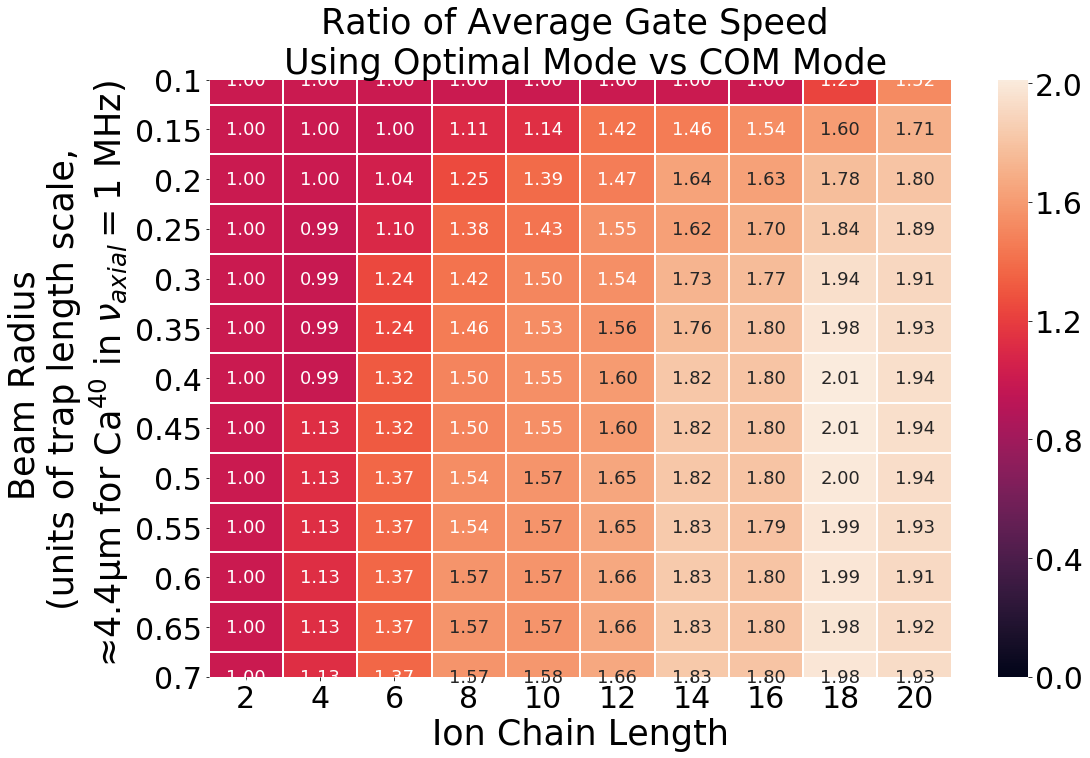

In [17]:
bw_vals_plot = bw_vals
chainlens_plot = [N for Ni,N in enumerate(chainlens) if N%2==0]

bw_labels = [round(bw,2) for bw in bw_vals_plot]

imps = {}
for N in chainlens:
    mvecs = ict.calcAxialModes(N)
    COMspeed = 1/N
    for bw in bw_vals:
        best_speeds = []
        for targets in combinations(range(N), 2):
            bestmode = bestmodes_axial[(N, targets, bw,"best")][0]
            speed = abs(mvecs[bestmode][1][targets[0]]*mvecs[bestmode][1][targets[1]])
            best_speeds.append(speed)
            #if speed<COMspeed:
            #    print(N, bestmode, targets, bw, speed/COMspeed)
        avg_speed_best = np.mean(best_speeds)
        imps[(N, bw)] = avg_speed_best/COMspeed
grid = np.zeros((len(chainlens_plot), len(bw_vals_plot)))
for Ni, N in enumerate(chainlens_plot):
    for bwi, bw in enumerate(bw_vals_plot):
        grid[Ni,bwi] = imps[(N, bw)]
        
fig, ax = plt.subplots(figsize=(16,10))

cbarax = sb.heatmap(ax=ax, data=grid.T, vmin=0, annot=True, fmt=".2f", linewidth=1,
       xticklabels=chainlens_plot, yticklabels=bw_labels, annot_kws={'fontsize':18})
cbarax.figure.axes[-1].tick_params(labelsize=30)
    
ax.tick_params(labelsize=30)

plt.yticks(rotation=0)


ax.set_xlabel("Ion Chain Length", fontsize=35)
ax.set_ylabel("Beam Radius \n (units of trap length scale, \n ≈4.4μm for Ca$^{40}$ in $ν_{axial} = 1$ MHz)", fontsize=35)


fig.tight_layout()
ax.set_title("Ratio of Average Gate Speed \n Using Optimal Mode vs COM Mode", fontsize=35)
plt.show()